## PSD+SVM Method

In [3]:
import os
import numpy as np
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from helper_functions import *
from latency_helpers import *
from loading_functions import *
from file_paths import *
from models import *
import importlib


import random

In [4]:
import importlib
import loading_functions
importlib.reload(loading_functions)
from loading_functions import *

### Load Features

In [24]:
feat_name = 'PSD'
t_seg = 20 #ms
n_per_seg = 1024
interferences = ['WIFI', 'BLUE', 'BOTH', 'CLEAN']
output_name = 'drones'
feat_format = 'ARR'
which_dataset = 'dronerf'
output_tensor = False

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    highlow = 'H'
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, output_tensor, highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, output_tensor, interferences)
X_use, y_use = dataset.get_arrays()

# Set fixed number of samples
# n_samps = 15500
# i_test= random.sample(range(len(dataset)), n_samps)
# # i_test= list(range(0,2712,10))
# X_use, y_use = dataset.__getitem__(i_test)
print(X_use.shape)

Loading DroneRF Dataset
Features_DroneRF/ARR_PSD_H_1024_20/
dataset size 24
shape of each item (513,)
(24, 513)


### Run Model

In [7]:
model = PsdSVM(t_seg, n_per_seg)

5it [00:00, 33.47it/s]


Fold 1: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.000601
Fold 2: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.0002
Fold 3: Accuracy: 0.4,	 F1: 0.4, 	 Runtime: 0.0
Fold 4: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.0
Fold 5: Accuracy: 0.5,	 F1: 0.333, 	 Runtime: 0.000276
PSD+SVM 5 Fold CV acc: 0.78, F1: 0.747, Run-time: 0.215ms


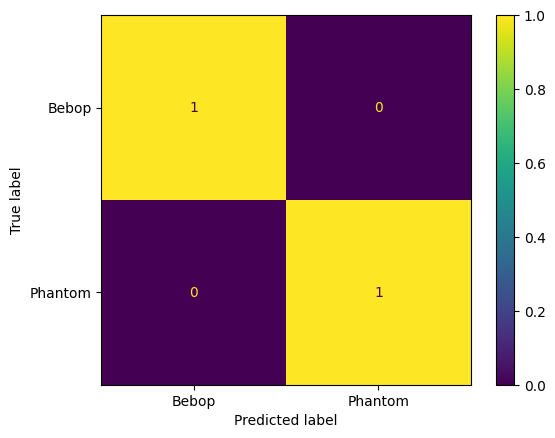

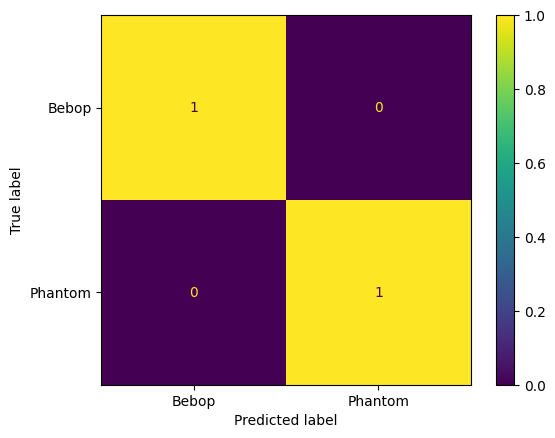

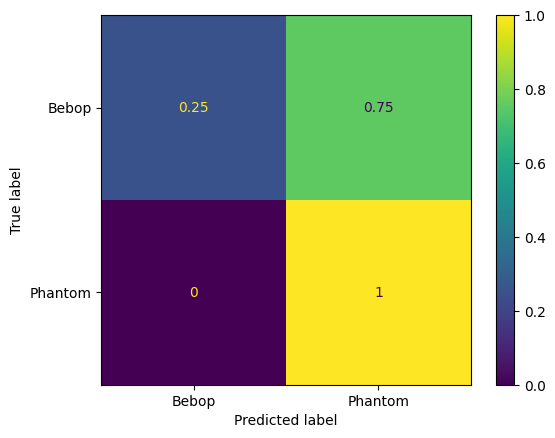

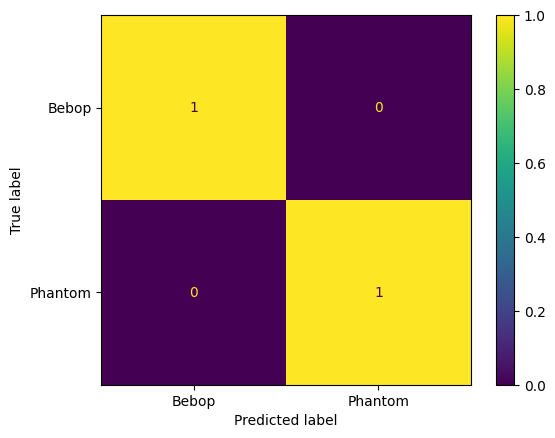

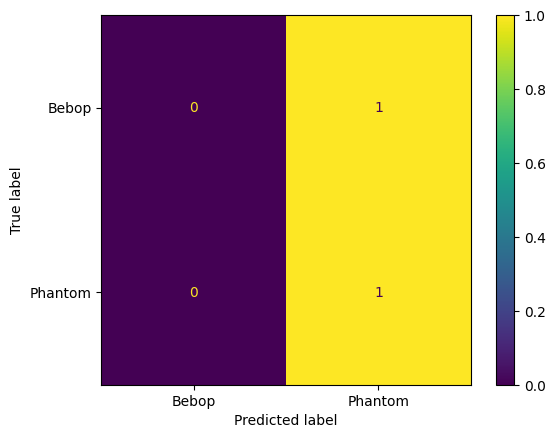

In [8]:
accs, f1s, runts = model.run_cv(X_use, y_use, k_fold=5)

In [9]:
for icv in range(5):
    print(model.cv_models[icv].support_vectors_.shape)

(15, 513)
(15, 513)
(12, 513)
(15, 513)
(13, 513)


In [10]:
np.mean([12345,12395,12450,12469,12383])

np.float64(12408.4)

In [11]:
# search through parameters
Cs=list(map(lambda x:pow(2,x),range(-3,10,2)))
gammas=list(map(lambda x:pow(2,x),range(-3,10,2)))
parameters = {'C':Cs, 'gamma':gammas}

k_fold=5

accs, f1s, runts, best_params = model.run_gridsearch(X_use, y_use, parameters, k_fold)

Fold 1 Best Parameters: {'C': 0.5, 'gamma': 2}
Fold 1: Accuracy: 0.6,	 F1: 0.633, 	 Runtime: 0.000202
Fold 2 Best Parameters: {'C': 0.5, 'gamma': 8}
Fold 2: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.0
Fold 3 Best Parameters: {'C': 0.5, 'gamma': 8}
Fold 3: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.000202
Fold 4 Best Parameters: {'C': 0.5, 'gamma': 32}
Fold 4: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.000208
Fold 5 Best Parameters: {'C': 0.125, 'gamma': 8}
Fold 5: Accuracy: 1.0,	 F1: 1.0, 	 Runtime: 0.000273
PSD+SVM 5 Fold GridSearch CV acc: 0.92, F1: 0.927, Run-time: 0.177ms


### Visualize Results

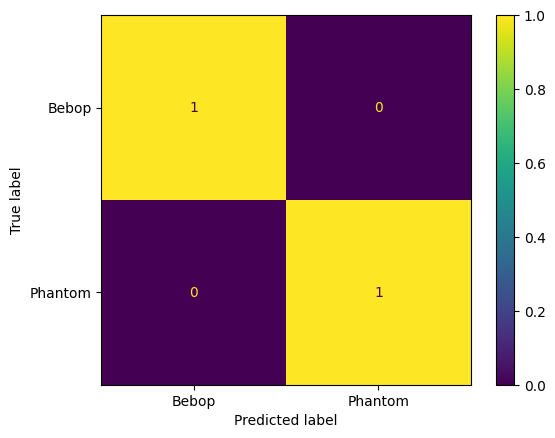

In [25]:
# Set-up train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_use, 
                                                    y_use, 
                                                    test_size=0.33, 
                                                    random_state=None)

# Train & Test
model.train(X_train, y_train)
preds = model.predict(X_test)
show_confusion_matrix(y_test, preds)

### Save Model

In [16]:
import pickle
import os

In [26]:
model_name = which_dataset + '_' + 'SVM' + '_' + str(feat_name) + '_' + str(n_per_seg) + '_' + str(t_seg) + '_' + str(int(to_train_all))
model_path = './models/'


os.makedirs(model_path, exist_ok=True)



# Save the trained model as a pickle file
save_filename = os.path.join(model_path, model_name + '.pkl')
with open(save_filename, 'wb') as f:
    pickle.dump(model, f)

print("Model saved to:", save_filename)

Model saved to: ./models/dronerf_SVM_PSD_1024_20_1.pkl


-----------------

## Open model

In [27]:

model_file = 'models\dronerf_SVM_PSD_1024_20_1.pkl'
try:
    with open(model_file, 'rb') as f:
        loaded_model = pickle.load(f)
    print("Model loaded successfully from:", model_file)
except FileNotFoundError:
    print("Model file not found:", model_file)

Model loaded successfully from: models\dronerf_SVM_PSD_1024_20_1.pkl


In [28]:
results = model.predict(X_test)

In [29]:
results

array(['Bebop', 'Phantom', 'Bebop', 'Bebop', 'Phantom', 'Bebop', 'Bebop',
       'Phantom'], dtype='<U7')

In [30]:
acc = accuracy_score(y_test, results)
print("Accuracy:", acc)

Accuracy: 1.0
